# 0. Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
cd /content/drive/MyDrive/colab-github/H2GCN/npz-datasets/

/content/drive/MyDrive/colab-github/H2GCN/npz-datasets


In [ ]:
# data.files

In [ ]:
!pip3 install deeprobust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 191 kB 30.7 MB/s 
     |████████████████████████████████| 125 kB 73.9 MB/s 
     |████████████████████████████████| 24.2 MB 67.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 25.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 3.5 MB 24.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 2.4 MB 39.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-euv489kn
  Running command git clone -q https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-euv489kn
  Created wheel for torch-geo

In [ ]:
import matplotlib.pyplot as plt
plt.set_cmap('Set3')

<Figure size 432x288 with 0 Axes>

# 1. Load dataset

In [ ]:
import torch

In [ ]:
#!/usr/bin/env python3
from dataset import CustomDataset
from torch_geometric.data import Data
from torch_geometric.utils import to_scipy_sparse_matrix, to_networkx, from_scipy_sparse_matrix

# Load the dataset in file `syn-cora/h0.00-r1.npz`
# `seed` controls the generation of training, validation and test splits
data_all = {}
rate =  ['00','10','20','30','40','50','60','70','80','90','99']
for i in np.arange(len(rate)): 
  data_all[i] = {}
  for j in np.arange(3):
      name = "h0."+rate[i]+"-r"+str(j+1)
      tmp = CustomDataset(root="syn-products", name=name, setting="gcn", seed=15)

      index, weight = from_scipy_sparse_matrix(tmp.adj )# Access adjacency matrix
      features = tmp.features # Access node features
      labels = tmp.labels


      data_all[i][j] = Data(x=torch.from_numpy(features.todense()).type(torch.float), y = labels,
                      edge_index= index, edge_weight = weight)
      data_all[i][j].num_classes =  data_all[i][j].y.max() + 1
      data_all[i][j].y = torch.from_numpy(data_all[i][j].y).type(torch.int64)

Loading h0.00-r1 dataset...
Loading h0.00-r2 dataset...
Loading h0.00-r3 dataset...
Loading h0.10-r1 dataset...
Loading h0.10-r2 dataset...
Loading h0.10-r3 dataset...
Loading h0.20-r1 dataset...
Loading h0.20-r2 dataset...
Loading h0.20-r3 dataset...
Loading h0.30-r1 dataset...
Loading h0.30-r2 dataset...
Loading h0.30-r3 dataset...
Loading h0.40-r1 dataset...
Loading h0.40-r2 dataset...
Loading h0.40-r3 dataset...
Loading h0.50-r1 dataset...
Loading h0.50-r2 dataset...
Loading h0.50-r3 dataset...
Loading h0.60-r1 dataset...
Loading h0.60-r2 dataset...
Loading h0.60-r3 dataset...
Loading h0.70-r1 dataset...
Loading h0.70-r2 dataset...
Loading h0.70-r3 dataset...
Loading h0.80-r1 dataset...
Loading h0.80-r2 dataset...
Loading h0.80-r3 dataset...
Loading h0.90-r1 dataset...
Loading h0.90-r2 dataset...
Loading h0.90-r3 dataset...
Loading h0.99-r1 dataset...
Loading h0.99-r2 dataset...
Loading h0.99-r3 dataset...


In [ ]:
from torch_geometric.datasets import WebKB
from torch_geometric.transforms import NormalizeFeatures
cornell_tmp = WebKB(root='WebKB', name='Cornell', transform=NormalizeFeatures())
cornell = cornell_tmp [0]  # Get the first graph object.

#2. Define Training Functions

In [ ]:
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math, random, torch, collections, time, torch.nn.functional as F, networkx as nx, matplotlib.pyplot as plt, numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from IPython.display import clear_output
from torch_geometric.utils import to_networkx
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from functools import wraps

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [ ]:
def visualize_graph(G, color, size=300, epoch=None, loss=None):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2", node_size=size)
    plt.show()


def visualize_tsne(out, color, size=30, epoch=None, loss=None):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()


def visualize_pca(out, color, size=30, epoch=None, loss=None):
    h = PCA(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(h[:, 0], h[:, 1], s=size, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss:.4f}', fontsize=16)
    plt.show()


def delete_undirected_edges(edge_index, p):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    edges = random.sample(edges, round(n * (1 - p)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1], x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()


def add_undirected_edges(edge_index, edge_num, node_total=2708):
    edges = torch.clone(edge_index).t().numpy()
    edges = set(map(frozenset, edges))
    n = len(edges)
    while len(edges) - n < edge_num:
        edges.add(frozenset(random.sample(range(node_total), 2)))
    edges = list(map(list, edges))
    reverse_edges = list(map(lambda x: [x[1], x[0]], edges))
    sample = sorted(edges + reverse_edges)
    return torch.tensor(sample).t().contiguous()


def dataset_print(dataset):
    print(f'Dataset: {dataset}:')
    print('======================')
    print(f'Number of graphs: {len(dataset)}')
    print(f'Number of features: {dataset.num_features}')
    print(f'Number of classes: {dataset.num_classes}')


def data_print(data):
    print(data)
    print('==============================================================')

    # Gather some statistics about the graph.
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Number of training nodes: {data.train_mask.sum()}')
    print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
    print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
    print(f'Contains self-loops: {data.contains_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')


def timethis(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print("Time to run function '{}': {:.2f} seconds".format(func.__name__, end - start))
        return result

    return wrapper


In [ ]:
from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor

import torch
from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.inits import zeros
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

from torch_geometric.datasets import WebKB
from torch_geometric.transforms import NormalizeFeatures
import torch
import torch_geometric as tg
import pandas as pd


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (Tensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> PairTensor  # noqa
    pass


@torch.jit._overload
def gcn_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
             add_self_loops=True, dtype=None):
    # type: (SparseTensor, OptTensor, Optional[int], bool, bool, Optional[int]) -> SparseTensor  # noqa
    pass


def gcn_no_norm(edge_index, edge_weight=None, num_nodes=None, improved=False,
                add_self_loops=True, dtype=None):
    fill_value = 2. if improved else 1.

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        return edge_index, edge_weight


def gcn_diffusion(edge_index, edge_weight=None, num_nodes=None, improved=False,
                  add_self_loops=True, dtype=None, alpha=0.5, beta = 1.0):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)  # sum of each row of the sparse tensor
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)  # put 0. where deg_inv_sprt == inf
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))  #### L_alpha = D^{-alpha}LD^{-alpha}
        deg = sparsesum(adj_t, dim=1)  #### degree D_alpha
        deg_inv = deg.pow_(-1)
        deg_inv.masked_fill_(deg == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv.view(1, -1))
        if add_self_loops == False:
            adj_t = fill_diag(adj_t, 1.)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        # print(deg)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        # print(scatter_add(L, col, dim=0, dim_size=data.num_nodes))
        deg_alpha = scatter_add(L, row, dim=0, dim_size=num_nodes)
        deg_inv = deg_alpha.pow_(-1)
        deg_inv.masked_fill_(deg == float('inf'), 0)
        L = deg_inv[row] * L
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


def gcn_norm(edge_index, edge_weight=None, num_nodes=None,
             improved=False,
             add_self_loops=True, dtype=None, alpha=0.5, beta = 1.0):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))
        if add_self_loops == False:
            adj_t = adj_t.fill_value(fill_value, dtype=dtype)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight

        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


def gcn_norm_sym(edge_index, alpha=0.5, beta = 1.0, edge_weight=None, num_nodes=None, improved=False,
                 add_self_loops=True, dtype=None):
    fill_value = beta

    if isinstance(edge_index, SparseTensor):
        adj_t = edge_index
        if not adj_t.has_value():
            adj_t = adj_t.fill_value(1., dtype=dtype)
        if add_self_loops:
            adj_t = fill_diag(adj_t, fill_value)
        deg = sparsesum(adj_t, dim=1)  # sum of each row of the sparse tensor
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0.)  # put 0. where deg_inv_sprt == inf
        adj_t = mul(adj_t, deg_inv_sqrt.view(-1, 1))
        adj_t = mul(adj_t, deg_inv_sqrt.view(1, -1))  #### L_alpha = D^{-alpha}LD^{-alpha}
        deg = sparsesum(adj_t, dim=1)  #### degree D_alpha
        deg_inv = deg.pow_(-0.5)
        deg_inv.masked_fill_(deg == float('inf'), 0.)
        adj_t = mul(adj_t, deg_inv.view(1, -1))
        adj_t = mul(adj_t, deg_inv.view(-1, 1))
        if add_self_loops == False:
            adj_t = fill_diag(adj_t, 1.)
        return adj_t

    else:
        num_nodes = maybe_num_nodes(edge_index, num_nodes)

        if edge_weight is None:
            edge_weight = torch.ones((edge_index.size(1),), dtype=dtype,
                                     device=edge_index.device)

        if add_self_loops:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, edge_weight, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            edge_weight = tmp_edge_weight
        row, col = edge_index[0], edge_index[1]
        deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
        # print(deg)
        deg_inv_sqrt = deg.pow_(-alpha)
        deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
        L = deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]
        # print(scatter_add(L, col, dim=0, dim_size=data.num_nodes))
        deg_alpha = scatter_add(L, row, dim=0, dim_size=num_nodes)
        deg_inv = deg_alpha.pow_(-0.5)
        deg_inv.masked_fill_(deg == float('inf'), 0)
        L = deg_inv[row] * L * deg_inv[col]
        if add_self_loops == False:
            edge_index, tmp_edge_weight = add_remaining_self_loops(
                edge_index, L, fill_value, num_nodes)
            assert tmp_edge_weight is not None
            L = tmp_edge_weight
        return edge_index, L


class AggregationScheme(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    The adjacency matrix can include other values than :obj:`1` representing
    edge weights via the optional :obj:`edge_weight` tensor.
    Its node-wise formulation is given by:
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
        \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
    with :math:`\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}`, where
    :math:`e_{j,i}` denotes the edge weight from source node :obj:`j` to target
    node :obj:`i` (default: :obj:`1.0`)
    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        normalize (bool, optional): Whether to add self-loops and compute
            symmetric normalization coefficients on the fly.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 gnn_type: str = "normal", alpha: float = 0.5,beta: float = 1.0,
                 bias: bool = True, **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(AggregationScheme, self).__init__(**kwargs)

        self.improved = improved
        self.cached = cached
        self.gnn_type = gnn_type
        self.alpha = alpha
        self.beta = beta
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

    def reset_parameters(self):
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index, edge_weight = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        print("here")
                        edge_index, edge_weight = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        print("here")
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    else:
                        edge_index, edge_weight = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha = self.alpha, beta = self.beta)
                    else:
                        edge_index = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, 0,
                                   0)


class GCNConv(MessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classification with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper
    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},
    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.
    The adjacency matrix can include other values than :obj:`1` representing
    edge weights via the optional :obj:`edge_weight` tensor.
    Its node-wise formulation is given by:
    .. math::
        \mathbf{x}^{\prime}_i = \mathbf{\Theta} \sum_{j \in \mathcal{N}(v) \cup
        \{ i \}} \frac{e_{j,i}}{\sqrt{\hat{d}_j \hat{d}_i}} \mathbf{x}_j
    with :math:`\hat{d}_i = 1 + \sum_{j \in \mathcal{N}(i)} e_{j,i}`, where
    :math:`e_{j,i}` denotes the edge weight from source node :obj:`j` to target
    node :obj:`i` (default: :obj:`1.0`)
    Args:
        in_channels (int): Size of each input sample, or :obj:`-1` to derive
            the size from the first input(s) to the forward method.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        cached (bool, optional): If set to :obj:`True`, the layer will cache
            the computation of :math:`\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
            \mathbf{\hat{D}}^{-1/2}` on first execution, and will use the
            cached version for further executions.
            This parameter should only be set to :obj:`True` in transductive
            learning scenarios. (default: :obj:`False`)
        add_self_loops (bool, optional): If set to :obj:`False`, will not add
            self-loops to the input graph. (default: :obj:`True`)
        normalize (bool, optional): Whether to add self-loops and compute
            symmetric normalization coefficients on the fly.
            (default: :obj:`True`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
        **kwargs (optional): Additional arguments of
            :class:`torch_geometric.nn.conv.MessagePassing`.
    """

    _cached_edge_index: Optional[Tuple[Tensor, Tensor]]
    _cached_adj_t: Optional[SparseTensor]

    def __init__(self, in_channels: int, out_channels: int,
                 improved: bool = False, cached: bool = False,
                 add_self_loops: bool = True, normalize: bool = True,
                 gnn_type: str = "normal", alpha: float = 0.5,beta: float = 1.0,
                 bias: bool = True,
                 **kwargs):

        kwargs.setdefault('aggr', 'add')
        super(GCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved
        self.cached = cached
        self.gnn_type = gnn_type
        self.alpha = alpha
        self.beta = beta
        self.add_self_loops = add_self_loops
        self.normalize = normalize

        self._cached_edge_index = None
        self._cached_adj_t = None

        self.lin = Linear(in_channels, out_channels, bias=False)
        torch.nn.init.xavier_normal_(self.lin.weight, gain=0.003)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        zeros(self.bias)
        self._cached_edge_index = None
        self._cached_adj_t = None

    def forward(self, x: Tensor, edge_index: Adj,
                edge_weight: OptTensor = None) -> Tensor:
        """"""

        if self.normalize:
            if isinstance(edge_index, Tensor):
                cache = self._cached_edge_index
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index, edge_weight = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index, edge_weight = gcn_diffusion(  # yapf: disable
                            edge_index,  edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    else:
                        edge_index, edge_weight = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_edge_index = (edge_index, edge_weight)
                else:
                    edge_index, edge_weight = cache[0], cache[1]

            elif isinstance(edge_index, SparseTensor):
                cache = self._cached_adj_t
                if cache is None:
                    if self.gnn_type == "normal":
                        edge_index = gcn_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "diffusion":
                        edge_index = gcn_diffusion(  # yapf: disable
                            edge_index,edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    elif self.gnn_type == "symmetric diffusion":
                        edge_index, edge_weight = gcn_norm_sym(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops, alpha=self.alpha, beta = self.beta)
                    else:
                        edge_index = gcn_no_norm(  # yapf: disable
                            edge_index, edge_weight, x.size(self.node_dim),
                            self.improved, self.add_self_loops)
                    if self.cached:
                        self._cached_adj_t = edge_index
                else:
                    edge_index = cache

        x = self.lin(x)
        # x2 = self.lin2(x)
        # propagate_type: (x: Tensor, edge_weight: OptTensor)
        out = self.propagate(edge_index, x=x, edge_weight=edge_weight,
                             size=None)

        if self.bias is not None:
            out += self.bias

        return out

    def message(self, x_j: Tensor, edge_weight: OptTensor) -> Tensor:
        return x_j if edge_weight is None else edge_weight.view(-1, 1) * x_j

    def message_and_aggregate(self, adj_t: SparseTensor, x: Tensor) -> Tensor:
        return matmul(adj_t, x, reduce=self.aggr)

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)

In [ ]:
mask = collections.namedtuple('mask', ('train', 'test'))  # tuple to store train mask, test mask

def train_one_epoch(model, criterion, optimizer, x, y, train_mask=None):  # x is a dictionary
    model.train()
    out, h = model(**x)
    loss = criterion(out, y) if train_mask is None else criterion(out[train_mask], y[train_mask])
    _, predicted = torch.max(out.detach(), 1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        if train_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item() / length
            misclassified = (predicted != y).numpy()
        else:
            length = len(y[train_mask])
            accuracy = (predicted[train_mask] == y[train_mask].detach()).sum().item() / length
            misclassified = (predicted[train_mask] != y[train_mask]).numpy()

    return out, loss.item(), accuracy, misclassified


def test(model, x, y, test_mask=None):  # x is a dictionary
    model.eval()
    with torch.no_grad():
        out, h = model(**x)
        _, predicted = torch.max(out, 1)
        if test_mask is None:
            length = len(y)
            accuracy = (predicted == y).sum().item() / length
        else:
            length = len(y[test_mask])
            accuracy = (predicted[test_mask] == y[test_mask]).sum().item() / length
    return accuracy, predicted[test_mask].numpy()


def plot_acc(train_acc, test_acc=None, xaxis='epochs', yaxis='accuracy', title='Accuracy plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    if test_acc is not None:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.plot(np.arange(len(test_acc)), test_acc, color='blue')
        plt.legend(['train accuracy', 'test accuracy'], loc='upper right')
    else:
        plt.plot(np.arange(len(train_acc)), train_acc, color='red')
        plt.legend(['train accuracy'], loc='upper right')
    plt.title(title)
    plt.tight_layout()
    plt.show()  # show train_acc and test_acc together


def plot_loss(loss, xaxis='epochs', yaxis='loss', title='Loss plot'):
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.plot(np.arange(len(loss)), loss, color='black')
    plt.title(title)
    plt.tight_layout()
    plt.show()


@timethis
def train(epochs, model, criterion, optimizer, x, y, m=mask(None, None),
          plotting=True, scatter_size=30, plotting_freq=5, dim_reduction='pca'):
    dim_reduction_dict = {'pca': visualize_pca, 'tsne': visualize_tsne}
    train_acc_list = []
    test_acc_list = []
    loss_list = []
    for epoch in range(epochs):
        out, loss, train_acc, misclassified = train_one_epoch(model, criterion, optimizer, x, y, m.train)
        model.eval()
        test_acc, predictions = test(model, x, y, m.test)
        train_acc_list.append(train_acc)
        loss_list.append(loss)
        test_acc_list.append(test_acc)
        if plotting:
            if epoch % plotting_freq == 0:
                clear_output(wait=True)
                dim_reduction_dict[dim_reduction](out, color=y, size=scatter_size, epoch=epoch, loss=loss)
    if plotting:
        if m == mask(None, None):
            plot_acc(train_acc_list)
        else:
            plot_acc(train_acc_list, test_acc_list)
        plot_loss(loss_list)
    print("Final test accuracy: {:.2f}".format(test_acc_list[-1]))
    return train_acc_list, test_acc_list, loss_list, misclassified, predictions, out

In [ ]:
## Modify original deg function so that they can have >1 dimensional input
def deg(index, num_nodes: Optional[int] = None,           
        dtype: Optional[torch.dtype] = None):
    r"""Computes the (unweighted) degree of a given one-dimensional index tensor.
    Args:
    index (LongTensor): Index tensor.
    num_nodes (int, optional): The number of nodes, *i.e.*
    :obj:`max_val + 1` of :attr:`index`. (default: :obj:`None`)
    dtype (:obj:`torch.dtype`, optional): The desired data type of the
    returned tensor.\n\n    :rtype: :class:`Tensor`\n    """
    if index.shape[0] != 1: # modify input 
        index = index[0] 
    N = maybe_num_nodes(index, num_nodes)
    out = torch.zeros((N, ), dtype=dtype, device=index.device)
    one = torch.ones((index.size(0), ), dtype=out.dtype, device=out.device)
    return out.scatter_add_(0, index, one)

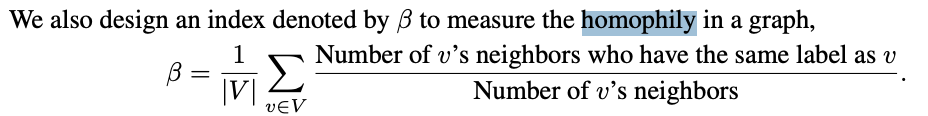




In [ ]:
from torch_geometric.utils import to_dense_adj
def node_homophily(data):
  relabel = data.y+1
  denom = data.num_nodes
  adj = to_dense_adj(data.edge_index)[0]
  deg = torch.sum(a,1)
  h = torch.div(torch.sum(torch.mul(data.y+1,a).t() == (data.y+1),1), torch.sum(a,1))
  return torch.sum(h)/denom


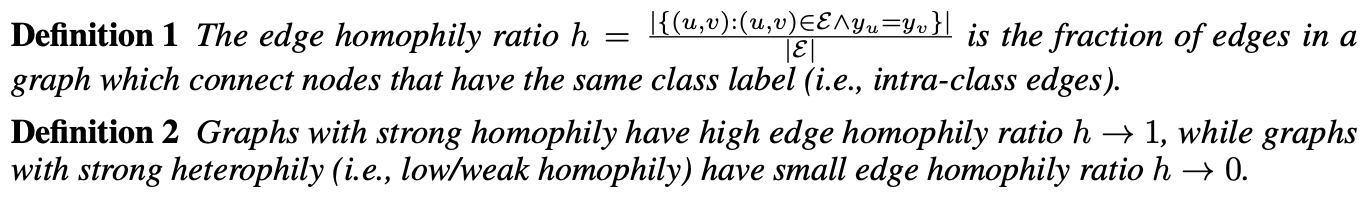

In [ ]:
def edge_homophily(data):
  denom = data.edge_index.shape[1]
  h = torch.sum(data.y[data.edge_index[0]] == data.y[data.edge_index[1]])
  return h/denom

In [ ]:
for i in np.arange(11):
  print(edge_homophily(data_all[i][0]))

tensor(0.)
tensor(0.0971)
tensor(0.2022)
tensor(0.2972)
tensor(0.3986)
tensor(0.4971)
tensor(0.5953)
tensor(0.6957)
tensor(0.7978)
tensor(0.8984)
tensor(0.9891)


#3. Experiments


In [ ]:
from torch.nn import Linear

class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels, dropout_rate=0.5,  gnn_type="normal", alpha=0, beta = 1,
                 add_self_loops= True,
                 seed = 12345, bias = True):
        super(GCN, self).__init__()
        torch.manual_seed(seed)
        self.conv1 = GCNConv(num_features, hidden_channels[0],  
                             gnn_type = gnn_type,
                             alpha = alpha, beta = beta,
                            add_self_loops = add_self_loops,
                            bias = bias)
        self.conv2 = GCNConv(hidden_channels[0], num_classes,
                            gnn_type = gnn_type,
                            alpha = alpha, beta = beta,
                            add_self_loops = add_self_loops, bias = bias)
        #self.lin1 = Linear(dataset.num_classes, dataset.num_classes)
        self.p = dropout_rate
        self.gnn_type = gnn_type 
        self.alpha = alpha
        self.seed = seed
        self.add_self_loops = add_self_loops = add_self_loops

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.p, training=self.training)
        x = self.conv2(x, edge_index)
        h = x
#         x = x.relu()
#         x = self.lin1(x)
        return x, h

model = GCN(num_features = data_all[0][1].num_features, num_classes = data_all[0][1].num_classes, hidden_channels=[32])
print(model)

GCN(
  (conv1): GCNConv(100, 32)
  (conv2): GCNConv(32, 10)
)


In [ ]:
import random
def masking(data, train_rate, seed):
  random.seed(seed)
  train_idx = random.choices(range(0,data.num_nodes), k=int(round(data.num_nodes*train_rate,0)))
  test_idx = list(set(range(0,data.num_nodes)) - set(train_idx))
  data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
  data.train_mask[train_idx] = 1
  data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
  data.test_mask[test_idx] = 1
  return data

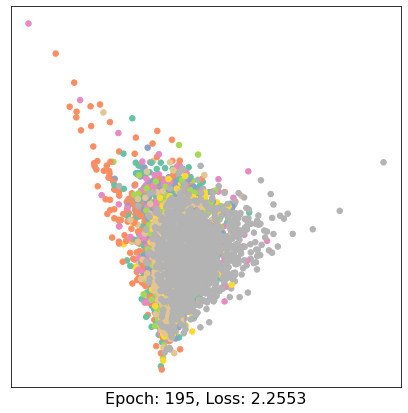

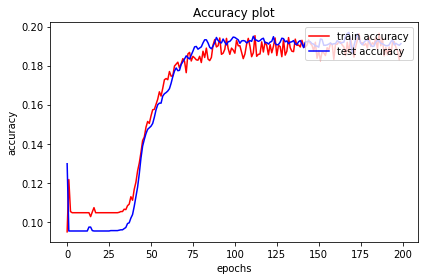

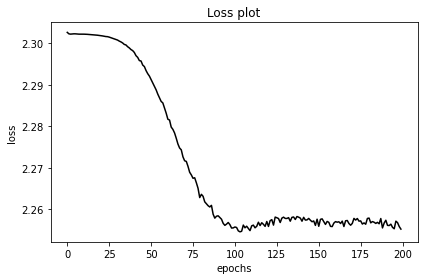

Final test accuracy: 0.19
Time to run function 'train': 32.10 seconds


In [ ]:
data = masking(data_all[0][1], 0.7, seed = 12345)
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
beta = 0.0
model = GCN(data.num_features, data.num_classes, hidden_channels=[32], gnn_type = experiment, alpha=1.0, beta = beta, seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(200, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

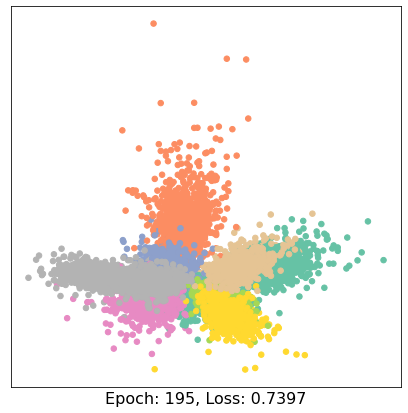

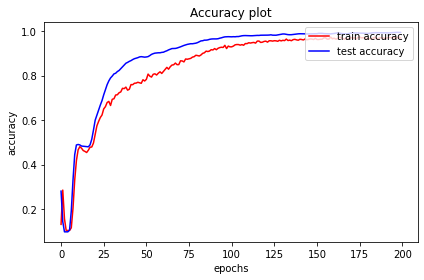

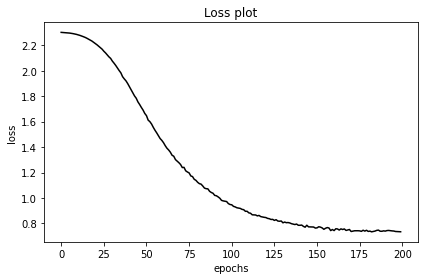

Final test accuracy: 0.99
Time to run function 'train': 31.39 seconds


In [ ]:
data = masking(data_all[10][1], 0.7, seed = 12345) # perfect homophily
n_train = data.train_mask.sum()
n_test = data.test_mask.sum() 
idx = torch.randperm(data.train_mask.shape[0])
train_mask = data.train_mask[idx].view(data.train_mask.size())
test_mask = ~train_mask
idx2  =  (torch.where(test_mask)[0]).numpy()
np.random.shuffle(idx2)
test_mask[idx2[n_test:]] = False

seed = 12345
experiment = 'normal'
beta = 0.0
model = GCN(data.num_features, data.num_classes, hidden_channels=[32], gnn_type = experiment, alpha=1.0, beta = beta, seed = seed)
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4) #didn't include weight decay

train_acc_list, test_acc_list, loss_list, _,  _ ,_= train(200, model, criterion, optimizer, 
                                         x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                       test_mask),
                                        scatter_size=30, plotting=True)

In [ ]:
random.randint(0,2)

1

In [ ]:
#n_train = data.train_mask.sum()
#n_test = data.test_mask.sum() 
n_exp = 10
results2 = {}
rate =  ['00','10','20','30','40','50','60','70','80','90','99']

for k in np.arange(11):
  dset = random.randint(0,2)
  data = masking(data_all[k][dset], 0.7, seed = 54321)
  for i in np.arange(n_exp):
      seed = i
      idx = torch.randperm(data.train_mask.shape[0])
      train_mask = data.train_mask[idx].view(data.train_mask.size())
      test_mask = ~train_mask
      idx2  =  (torch.where(test_mask)[0]).numpy()
      np.random.shuffle(idx2)
      test_mask[idx2[n_test:]] = False
      
      for experiment in ["normal", "diffusion"]:
          for beta in [0.01,0.1,0.2,0.5,0.7,1,2,5,10,50]:
              model = GCN(data.num_features, data.num_classes, hidden_channels=[32], gnn_type = experiment, alpha=1.0, beta = beta,
                          seed = seed)
              criterion = torch.nn.CrossEntropyLoss() 
              optimizer = torch.optim.Adam(model.parameters(), lr=0.02, weight_decay=5e-4) #didn't include weight decay

              train_acc_list, test_acc_list, loss_list, _,  _, out_tmp = train(200, model, criterion, optimizer, 
                                                      x={'x': data.x, 'edge_index': data.edge_index}, y=data.y, m=mask(train_mask, 
                                                                                                                    test_mask),
                                                      scatter_size=30, plotting=False)
              results2['Prod-syn_' + str(k) + experiment + '_' + str(beta) + '_' +  str(i)]  =  {'train_acc': train_acc_list[-1],
                                          'test_acc': test_acc_list[-1],
                                          'seed' : model.seed,
                                          'gnn_type': experiment,
                                          'embedding' : out_tmp,
                                          'exp number': i,
                                          'alpha': 1,
                                          'beta': beta,
                                          'homophily': rate[k],
                                          'set_num': dset,
                                          'dataset' : 'Product-syn'}   
              print(rate[k] + '_' + experiment + '_' + str(beta) + '_' +  str(i))

Final test accuracy: 0.20
Time to run function 'train': 19.87 seconds
00_normal_0.01_0
Final test accuracy: 0.20
Time to run function 'train': 19.19 seconds
00_normal_0.1_0
Final test accuracy: 0.21
Time to run function 'train': 18.45 seconds
00_normal_0.2_0
Final test accuracy: 0.19
Time to run function 'train': 18.26 seconds
00_normal_0.5_0
Final test accuracy: 0.17
Time to run function 'train': 18.89 seconds
00_normal_0.7_0
Final test accuracy: 0.16
Time to run function 'train': 18.51 seconds
00_normal_1_0
Final test accuracy: 0.16
Time to run function 'train': 18.39 seconds
00_normal_2_0
Final test accuracy: 0.10
Time to run function 'train': 18.37 seconds
00_normal_5_0
Final test accuracy: 0.10
Time to run function 'train': 18.35 seconds
00_normal_10_0
Final test accuracy: 0.10
Time to run function 'train': 18.37 seconds
00_normal_50_0
Final test accuracy: 0.63
Time to run function 'train': 19.16 seconds
00_diffusion_0.01_0
Final test accuracy: 0.62
Time to run function 'train': 1

In [ ]:
import pickle

# Store data 
with open('syn-prod-beta-multiple.pkl', 'wb') as file:
    # A new file will be created
    pickle.dump(results2, file)

In [ ]:
#import pickle
# with open(r"syn-cora-beta.pkl", "rb") as input_file:
#      results = pickle.load(input_file)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

tab = pd.DataFrame.from_dict(results).T
#tab['train_acc','homophily','beta']
tab['test_acc'] = tab['test_acc'].astype(float) 
tab['beta'] = tab['beta'].astype(float) 
tab['homophily'] = tab['homophily'].astype(float)/100

In [ ]:
tab_normal = tab[tab["gnn_type"] == "normal"]
tab_reg = tab[tab["gnn_type"] == "diffusion"]

In [ ]:
result_normal = pd.pivot_table(tab_normal, index = ['homophily'], columns = ['beta'],values= ['test_acc'],aggfunc = {'test_acc':np.mean})
result_reg =  pd.pivot_table(tab_reg, index = ['homophily'], columns = ['beta'],values= ['test_acc'],aggfunc = {'test_acc':np.mean})

In [ ]:
result_normal.stack().reset_index().pivot(index='homophily', columns='beta', values='test_acc')

beta,0.01,0.10,0.20,0.50,0.70,1.00,2.00,5.00,10.00,50.00
homophily,,,,,,,,,,
0.00,0.181123,0.186557,0.189173,0.179513,0.169853,0.164218,0.152747,0.093580,0.093580,0.093580
0.10,0.202656,0.206883,0.209499,0.208493,0.211511,0.209298,0.208895,0.196015,0.096398,0.096398
0.20,0.215134,0.217750,0.217951,0.225397,0.224995,0.226404,0.233850,0.229020,0.095593,0.095593
0.30,0.238881,0.242705,0.242504,0.241497,0.240692,0.243912,0.252968,0.253572,0.096398,0.096398
0.40,0.333467,0.338096,0.340310,0.346750,0.350775,0.349970,0.356007,0.357215,0.218555,0.094989
0.50,0.553633,0.562085,0.567720,0.583417,0.582008,0.582612,0.561884,0.443550,0.267458,0.095995
0.60,0.629100,0.639565,0.643993,0.656068,0.656269,0.654458,0.651238,0.561481,0.305293,0.095391
0.70,0.743208,0.747434,0.752063,0.758704,0.764138,0.756691,0.740994,0.639364,0.367076,0.095593
0.80,0.840612,0.842826,0.844033,0.842222,0.841618,0.834977,0.815456,0.697323,0.418998,0.095190


In [ ]:
result_reg.stack().reset_index().pivot(index='homophily', columns='beta', values='test_acc')

beta,0.01,0.10,0.20,0.50,0.70,1.00,2.00,5.00,10.00,50.00
homophily,,,,,,,,,,
0.00,0.644395,0.635339,0.617831,0.568525,0.531697,0.503119,0.431274,0.423023,0.501107,0.670759
0.10,0.572550,0.570940,0.565707,0.538539,0.524049,0.503924,0.477762,0.497887,0.556852,0.701147
0.20,0.559670,0.570739,0.573154,0.571946,0.566512,0.565104,0.547796,0.576172,0.641980,0.732944
0.30,0.621252,0.637352,0.646609,0.649628,0.653049,0.652244,0.651640,0.683437,0.723486,0.764741
0.40,0.697323,0.712014,0.720467,0.725297,0.727712,0.737975,0.749245,0.778024,0.804186,0.804790
0.50,0.797746,0.809418,0.818273,0.831153,0.838599,0.838599,0.843027,0.855102,0.863152,0.826927
0.60,0.876233,0.885289,0.890320,0.899577,0.900181,0.898772,0.899577,0.899577,0.896760,0.843228
0.70,0.938016,0.941437,0.945663,0.947273,0.947273,0.946066,0.943047,0.935601,0.922922,0.853089
0.80,0.980680,0.982693,0.984504,0.984705,0.985913,0.985510,0.982491,0.973637,0.960153,0.882471


<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, 'Test accuracy on symmetric operator across $\\beta$, $\\alpha=1$')

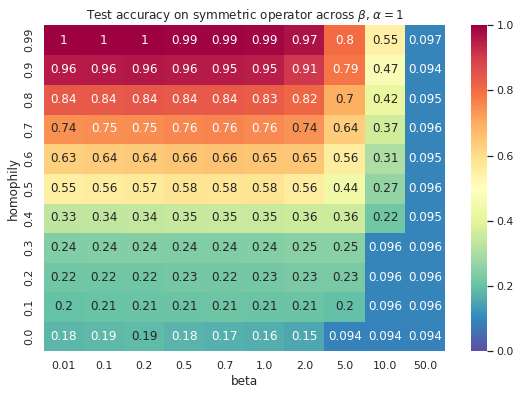

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(9,6))
sns.set(font_scale=1)
ax = sns.heatmap(result_normal.stack().reset_index().pivot(index='homophily', columns='beta', values='test_acc'), annot=True, vmin=0, vmax=1, cmap = "Spectral_r") #cmap = sns.cm.rocket_r
ax.set_title(r'Test accuracy on symmetric operator across $\beta$, $\alpha=1$')
ax.invert_yaxis()

<Figure size 648x432 with 0 Axes>

Text(0.5, 1.0, 'Test accuracy on row-normalized operator across $\\beta$, $\\alpha=1$')

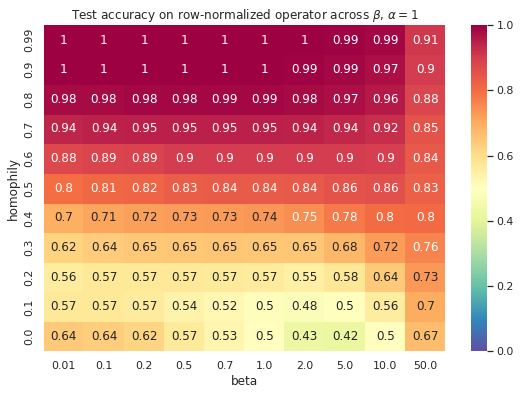

In [ ]:
plt.figure(figsize=(9,6))
sns.set(font_scale=1)
ax = sns.heatmap(result_reg.stack().reset_index().pivot(index='homophily', columns='beta', values='test_acc'), annot =True, vmin=0, vmax=1, cmap = "Spectral_r") #cmap = sns.cm.rocket_r
ax.set_title(r'Test accuracy on row-normalized operator across $\beta$, $\alpha=1$')
ax.invert_yaxis()